In [1]:
import numpy as np
import math
import pickle
import os
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


# What is convolution?

$$ 
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) \, d\tau
$$

# suppose we have 2 functions

In [2]:
def function_f(t):
    return math.sin(t - 5) 

def function_g(t):
    return math.sin(t)

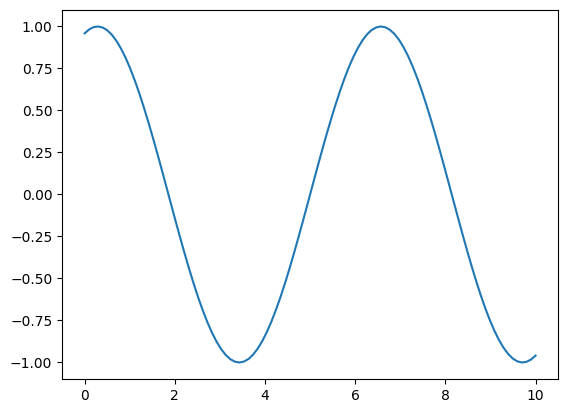

In [3]:
time = np.linspace(0, 10, 100)

fn_f_on_time = [function_f(t) for t in time]

plt.plot(time, fn_f_on_time)

In [4]:
tau = 0
integral_mult_results = []


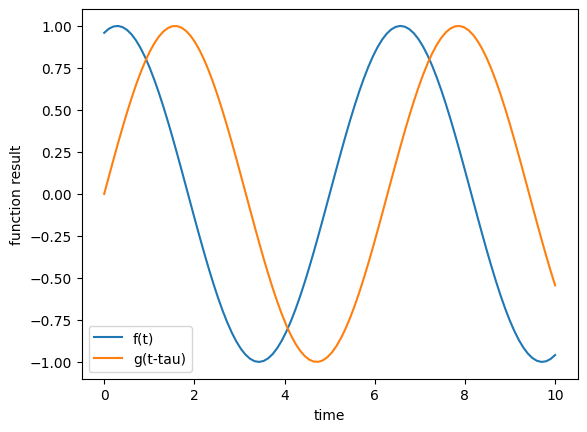

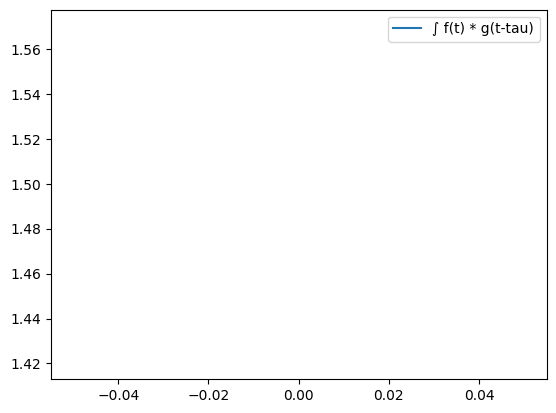

In [5]:
fn_g_on_time_shifted = [function_g(t - tau) for t in time]

plt.plot(time, fn_f_on_time, label="f(t)")
plt.xlabel("time")
plt.ylabel("function result")
plt.plot(time, fn_g_on_time_shifted, label="g(t-tau)")

plt.legend()
plt.show()


int_f_mult_g = np.trapz(np.array(fn_f_on_time) * np.array(fn_g_on_time_shifted), time)
integral_mult_results.append(int_f_mult_g)

plt.plot(integral_mult_results, label="∫ f(t) * g(t-tau)")
plt.legend()


tau += 1

# Introduction

In [6]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

partition = 1
train_images = train_images[:int(len(train_images) * partition)]
train_labels = train_labels[:int(len(train_labels) * partition)]

# # Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


test_images.shape, train_images.shape

((10000, 28, 28), (60000, 28, 28))

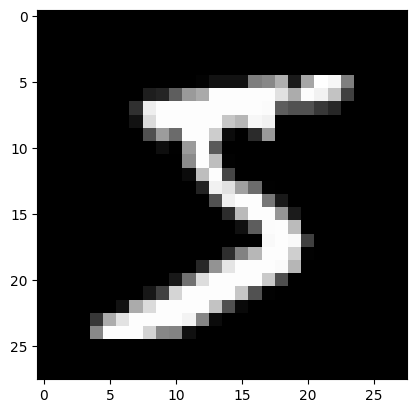

In [7]:
img_0 = train_images[0]
plt.imshow(img_0, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8323865658210464..0.907699590393917].


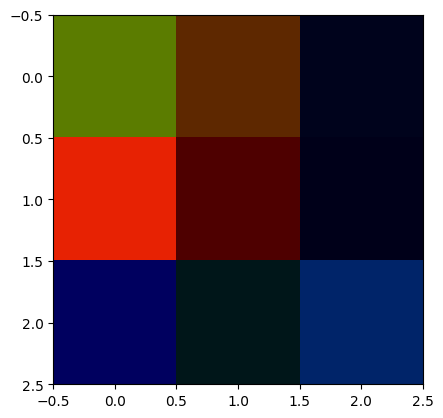

In [8]:
def get_filter(size, c=1):
    h, w = size
    return np.random.randn(h, w, c) / math.sqrt(h * w)

rand_filter = get_filter((3, 3), 3)
plt.imshow(rand_filter)

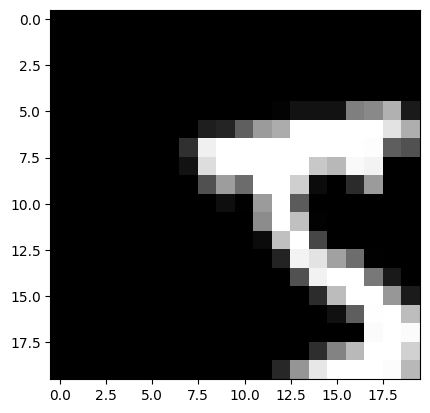

In [9]:
row = 0
col = 0
w = 20
h = 20

plt.imshow(
    img_0[row:row + h, col:col + w],
    cmap='gray'
)

In [10]:
def matrix_walker(image, fn, size, stride):
    size_w, size_h = size

    new_image = []

    range_i = range(0, len(image) - size_w + 1, stride)
    range_j = range(0, len(image[0]) - size_h + 1, stride)

    # print(f"Range over width: {list(range_i)}, Range over height: {list(range_j)}")

    for i in range_i:
        new_image.append([])  
        for j in range_j:
            sub_matrix = image[i:i + size_w, j:j + size_h]

            total_index = i * len(image[0]) + j

            new_image[-1].append(fn(sub_matrix, total_index))  

    return new_image


(22, 28)

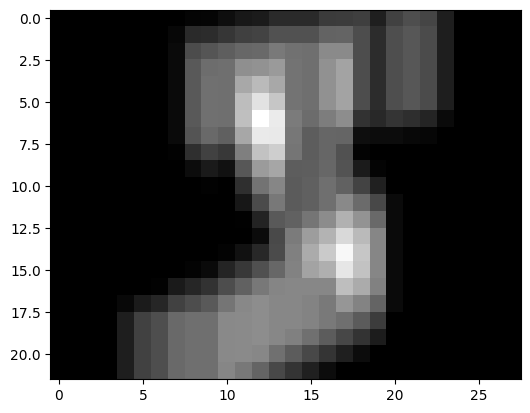

In [11]:
filter_size = (7, 1)
stride = 1
img_conv_example = matrix_walker(
    img_0,
    lambda x, _: np.sum(x), 
    size=filter_size, 
    stride = stride,
)

plt.imshow(img_conv_example, cmap='gray')
np.array(img_conv_example).shape

# 1 Layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.458386171755194].


(3, 5, 5, 1) filters shape


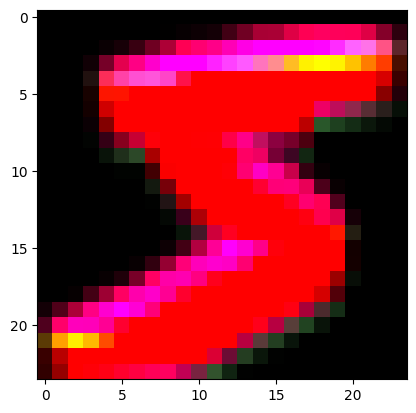

In [12]:
filter_size = (5, 5)
stride = 1

filter_size2 = 5
stride2 = 1

pool_0_size = 2
pool_0_stride = 2   

filters = np.array([get_filter(filter_size) for _ in range(3)])
biases = np.array([0, 0, 0])

print(filters.shape, 'filters shape')


def relu(x):
    return np.maximum(0, x)

def cross_cor(x):
    result = []

    for i in range(len(filters)):
        result.append(
            relu(np.sum(x * filters[i]) + biases[i])
        )

    return result

# convolution filter 1
output_img_0 = matrix_walker(
    img_0,
    lambda x, _: cross_cor(x), 
    filter_size, 
    stride,
)

# 28x28 -> 10x10

np.array(output_img_0).shape

plt.imshow(output_img_0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8244752103321833..2.1935081982676956].


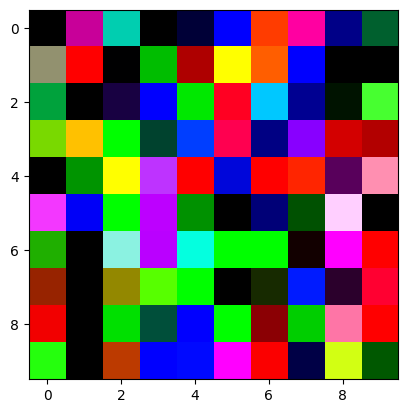

In [13]:
# random matrix
rand_img = np.random.randn(10, 10, 3)
plt.imshow(rand_img)

(-0.3842025598222746,
 [-0.3842025598222746,
  -0.08886113015784204,
  -1.5309252049046111,
  -5.550942123605793,
  -0.357157990985082,
  5.912287510557291,
  4.658706152106119,
  0.33746009136149124,
  -4.1749607481295525],
 (2, 2, 3))

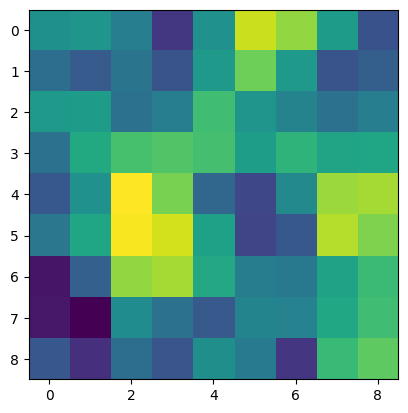

In [14]:
sum_relu = matrix_walker(
    rand_img,
    lambda x, _: np.sum(x), 
    (2, 2),
    1,
)

plt.imshow(sum_relu)

first_lamda_call = rand_img[0:2, 0:2]

np.sum(first_lamda_call), sum_relu[0], first_lamda_call.shape

In [15]:
class LayerConv2D:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))

    def df_activation(self):
        """
            activated_output -> aL = σ(zL)
        """
        # activated_output = np.clip(activated_output, -500, 500)
        activated_output = self.output
        
        if self.activation == LayerConv2D.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerConv2D.relu:
            return np.where(activated_output <= 0, 0, 1)

    def init_filters(self):
        w, h = self.filter_dim
        
        self.weights = np.random.randn(
            self.filters_count, 
            w, 
            h, 
            self.channels
        ) / math.sqrt(h * w)

    def init_biases(self):
        self.biases = np.zeros(self.filters_count)

    def set_channels(self, images):
        self.channels = images.shape[-1]
    
    def __init__(self, filters_count, filter_dim, stride=1, channels=None, activation=relu):
        self.filters_count = filters_count
        self.filter_dim = filter_dim
        self.stride = stride

        self.activation = activation
        self.channels = channels

        if (self.channels is not None):
            self.init_filters()

        self.init_biases()

    def cross_cor(self, x, _):
        result = []

        for i in range(len(self.weights)):
            result.append(
                self.activation(
                    np.sum(x * self.weights[i]) + self.biases[i]
                )
            )

        return result


    def forward(self, images):
        '''
           [ image, width, height, inputChannels ]
           # for input channel is equal to the number of colors (3 for RGB) or the number of filters from the previous layer
           # for the output channel is equal to the number of filters

           return [ image, width, height, outputChannels ]
        '''

        if (self.channels is None):
            self.set_channels(images)
            self.init_filters()

        self.output = []

        for image, image_idx in zip(images, range(len(images))):
            # ... width, height, channels ]
            self.output.append(matrix_walker(
                image,
                self.cross_cor,
                self.filter_dim,
                self.stride,
            ))
                
        self.output = np.array(self.output)
        
        return self.output


class LayerMaxPooling2D:
    def __init__(self, filter_dim, stride=1):
        self.filter_dim = filter_dim
        self.stride = stride
        self.indexes = []

    def max_pool(self, x, _):
        maximum = np.max(x, axis=(0, 1))
        max_index = np.unravel_index(
            np.argmax(x), 
            x.shape
        )
        
        self.indexes.append(max_index)
        
        return maximum
        

    def forward(self, images):
        self.output = []
        self.indexes = []

        for image in images:
            self.output.append(
                matrix_walker(
                    image,
                    self.max_pool,
                    self.filter_dim,
                    self.stride,
                )
            )

        self.output = np.array(self.output)
        return self.output


class LayerFlatten:
    input_shape = None
    output_shape = None

    def forward(self, images):
        self.output = []

        for image in images:
            self.output.append(image.flatten())

        self.output = np.array(self.output)

        if self.input_shape is None:
            self.input_shape = images[0].shape
            self.output_shape = self.output[0].shape

        return self.output





In [147]:
x = np.random.randn(2, 3, 4)
print(x)

[[[-0.03554575 -0.99455335  0.95937743 -1.75869244]
  [ 0.07694004  0.70221476  0.84320068 -0.60153024]
  [-0.8874375   0.20874065  1.49227311  0.87040757]]

 [[ 0.38542408 -1.02547147  0.11785638  3.30509536]
  [ 0.43631441 -0.14314998 -1.33666134 -0.69107653]
  [-0.69199934  0.88229169  0.2125935  -2.42145335]]]


In [82]:
# [
#    0ch (x, y)
#    1ch (x, y)
#    2ch (x, y)
#    ...
# ]

# reshape to find arg max for each channel, (flat columns and find max element index )

In [148]:
x_s, y_s, c_s = x.shape

transformed_array = x.transpose(2, 0, 1).reshape(c_s, x_s * y_s)
print(transformed_array)

[[-0.03554575  0.07694004 -0.8874375   0.38542408  0.43631441 -0.69199934]
 [-0.99455335  0.70221476  0.20874065 -1.02547147 -0.14314998  0.88229169]
 [ 0.95937743  0.84320068  1.49227311  0.11785638 -1.33666134  0.2125935 ]
 [-1.75869244 -0.60153024  0.87040757  3.30509536 -0.69107653 -2.42145335]]


In [200]:
max_index_transposed_channels = np.argmax(transformed_array, axis=1)
max_index_transposed_channels

array([4, 5, 2, 3], dtype=int64)

# restore-convert these indexes to 3 dim to easy picking

# 0 -> (y_s - 1)  index 0
# y_s -> (y_s - 1)*2  index 1

In [215]:
col = 0 # 0, 1 , 2 ,3 index
5// (y_s), 8%3 * c_s + col

(1, 8)

In [218]:
max_index_restored_channels = [
    (mitc // (y_s), mitc % y_s, i) for mitc, i in zip(max_index_transposed_channels, range(len(max_index_transposed_channels)))
]
max_index_restored_channels

[(1, 1, 0), (1, 2, 1), (0, 2, 2), (1, 0, 3)]

# testing

In [217]:
max_values = np.max(x, axis=(0, 1))
max_values, [x[i] for i in max_index_restored_channels], np.max(transformed_array, axis=1)

(array([0.43631441, 0.88229169, 1.49227311, 3.30509536]),
 [0.43631440552374534,
  0.8822916902374557,
  1.4922731137586442,
  3.3050953641662955],
 array([0.43631441, 0.88229169, 1.49227311, 3.30509536]))

In [ ]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images))
    for ax, index in zip(axs, range(len(images))):
        ax.axis('off')
        ax.title.set_text(f'{index}')

    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')

    plt.show()


In [ ]:
img_0[22][14], img_0.reshape(28, 28, 1)[22][14][0]

(0.3137254901960784, 0.3137254901960784)

In [ ]:
# width, height -> width, height, channels
reshaped_gray_train_images = np.array(train_images.reshape(len(train_images), 28, 28, 1))
reshaped_gray_train_images.shape

(60000, 28, 28, 1)

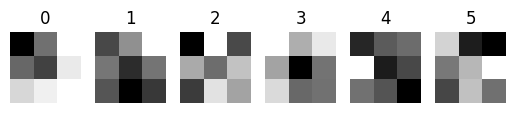

(5, 5808)

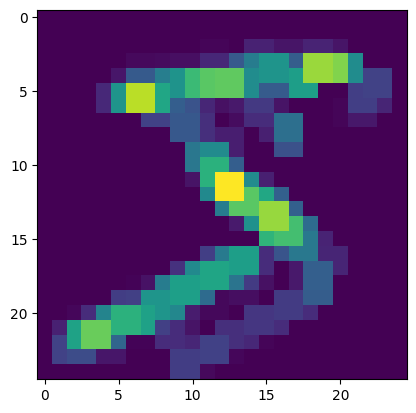

In [ ]:
# 1 layer
# almost done, just verify whether we should all images passed to conv? and what about if we pass multiple images for batch training?
layer_0 = LayerConv2D(
    filters_count=6,
    filter_dim=(3, 3),
    stride=1,
    channels=1
)

layer_output_0 = layer_0.forward(reshaped_gray_train_images[:5])
layer_output_0 = LayerMaxPooling2D((2, 2)).forward(layer_output_0)

# 2 layer
layer_1 = LayerConv2D(
    filters_count=12,
    filter_dim=(4, 4),
    stride=1,
    channels= 1 * 6
)
layer_output_1 = layer_1.forward(layer_output_0)
layer_output_1 = LayerFlatten().forward(layer_output_1)

# print(np.array(output).shape)
plot_images(layer_0.weights)
 
plt.imshow(np.array(layer_output_0)[0, :, :, 5:6]) # image 0, all width, all height, 5th channel == filters' index
layer_output_1.shape

In [ ]:
# total_images = layer_output_1.shape[0]

# layer_output_1.shape, layer_output_1.reshape(total_images, -1).shape, LayerFlatten().forward(layer_output_1).shape

C:\Users\ferra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


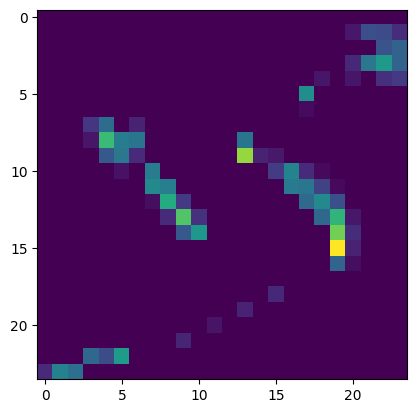

In [ ]:
import tensorflow as tf

tf_conv_layer = tf.keras.layers.Conv2D(7, (5, 5), activation='relu', input_shape=(28, 28, 1), strides=1)
# forward
tf_conv_layer_output = tf_conv_layer(np.expand_dims(train_images[0:50], -1)).numpy()

plt.imshow(tf_conv_layer_output[0, :, :, 3])


In [ ]:


class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs
    
    
    def df_activation(self):
        """
            activated_output -> aL = σ(zL)
            the forward should be called before this method
        """
        activated_output = self.output

        if self.activation == LayerDense.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerDense.relu:
            return np.where(activated_output <= 0, 0, 1)
        elif self.activation == LayerDense.softmax:
            batch_size = activated_output.shape[0]
            # Initialize the tensor for storing the derivatives
            d_softmax = np.zeros((batch_size, activated_output.shape[1], activated_output.shape[1]))
            for i in range(batch_size):
                s = activated_output[i].reshape(-1, 1)
                d_softmax[i] = np.diagflat(s) - np.dot(s, s.T)

            return d_softmax

    def set_inputs_len(self, inputs):
        self.inputs_len = inputs.shape[1]

    def init_weights(self):
        #  Kaiming initialization
        self.weights = np.random.randn(self.inputs_len, self.neurons_len) * np.sqrt(2. / self.inputs_len)

    def init_biases(self):
        self.biases = np.zeros(self.neurons_len)

    def __init__(self, neurons_len, activation=relu):
        self.inputs_len = None
        self.neurons_len = neurons_len
        self.activation = activation
        # self.init_weights()
        self.init_biases()

    def forward(self, inputs):
        if (self.inputs_len is None):
            self.set_inputs_len(inputs)
            self.init_weights()

        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)
        return self.output


class NeuralNetwork:
    @staticmethod
    def load(path) -> 'NeuralNetwork':
        with open(path, 'rb') as f:
            return pickle.load(f)

    def save(self, name, folder=''):
        hyperparameters = f'{self.learning_rate}_{self.epochs}_{self.batch_size}_{self.train_size}'
        filename = name + '_' + hyperparameters + '.pkl'
        path = os.path.join(folder, filename)

        with open(path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def loss_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    @staticmethod
    def df_loss_mse(y_true, y_pred):
        return y_pred - y_true
    
    @staticmethod
    def loss_binary_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def loss_categorical_crossentropy(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
        loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        return loss

    def __init__(self, loss=loss_mse, log=True):
        self.log = log
        self.loss = loss
        self.history_accuracy = []
        self.history_loss = []
        self.history_val_accuracy = []
        self.history_val_loss = []
        self.layers = []

        # hyperparameters
        self.learning_rate = 0.01
        self.epochs = 10
        self.batch_size = 10
        self.validation_split = 0.1
        self.train_size = 0


    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

        return inputs
    
    def calculate_output_delta(self, layer, y_true, y_pred):
        if layer.activation == LayerDense.softmax:
            return y_pred - y_true
        if layer.activation == LayerDense.sigmoid:
            grad_loss_input = self.df_loss_mse(y_true, y_pred) # derivative of loss function = ∇aL | samples -> neurons
            activation_derivative = layer.df_activation() # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) | samples -> neurons

            return grad_loss_input * activation_derivative # δL = ∇aL * σ'(zL) | samples -> neurons

    def backward_auto(self, inputs, y_true, y_pred, lr, batch_size):
        layers_count = len(self.layers)

        for layer_index in reversed(range(0, layers_count)):
            layer = self.layers[layer_index]

            is_output_layer = layer_index == layers_count - 1

            if is_output_layer:
                # output layer
                layer.delta = self.calculate_output_delta(layer, y_true, y_pred)
                # print(layer.delta)
            else:
                prev_backward_layer = self.layers[layer_index + 1]        

                layer.propagated_error = prev_backward_layer.delta @ prev_backward_layer.weights.T # δL * wL.T

                layer.activation_derivative = layer.df_activation() 
                layer.delta = layer.propagated_error * layer.activation_derivative

            if layer_index != 0:
                next_backward_layer = self.layers[layer_index - 1]

                next_backward_layer_output = next_backward_layer.output.T
            else:
                next_backward_layer_output = inputs.T

            layer.grad_loss_weights = np.dot(next_backward_layer_output, layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
            layer.grad_loss_biases = np.sum(layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

            # clip the gradients to prevent exploding gradients
            np.clip(layer.grad_loss_weights, -1, 1, out=layer.grad_loss_weights)  
            np.clip(layer.grad_loss_biases, -1, 1, out=layer.grad_loss_biases)

            layer.weights = layer.weights - lr * layer.grad_loss_weights / batch_size
            layer.biases = layer.biases - lr * layer.grad_loss_biases / batch_size


    def backward_manual(self, inputs, y_true, y_pred, lr, batch_size):
        output_layer = self.layers[-1]

        output_layer.delta = self.calculate_output_delta(output_layer, y_true, y_pred)

        layer_2_backward_layer_output = self.layers[-2].output.T
        output_layer.grad_loss_weights = np.dot(layer_2_backward_layer_output, output_layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
        output_layer.grad_loss_biases = np.sum(output_layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

        output_layer.weights = output_layer.weights - lr * output_layer.grad_loss_weights / batch_size
        output_layer.biases = output_layer.biases - lr * output_layer.grad_loss_biases / batch_size

        # next layer
        first_FC_layer_index = -2
        first_FC_layer = self.layers[first_FC_layer_index]

        first_FC_layer.propagated_error = output_layer.delta @ output_layer.weights.T # δL * wL.T
        first_FC_layer.activation_derivative = first_FC_layer.df_activation() 
        
        first_FC_layer.delta = first_FC_layer.propagated_error * first_FC_layer.activation_derivative

        # if it is the last layer for backward we wil take inputs.T 
        flatten_backward_layer_output = self.layers[first_FC_layer_index - 1].output.T # inputs.T # inputs.T
        first_FC_layer.grad_loss_weights = np.dot(flatten_backward_layer_output, first_FC_layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
        first_FC_layer.grad_loss_biases = np.sum(first_FC_layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

        first_FC_layer.weights = first_FC_layer.weights - lr * first_FC_layer.grad_loss_weights / batch_size
        first_FC_layer.biases = first_FC_layer.biases - lr * first_FC_layer.grad_loss_biases / batch_size

        # next layer flatten layer


        flatten_layer_index = first_FC_layer_index - 1
        flatten_layer = self.layers[flatten_layer_index]

        # not sure that i should reshape after dot product or saparately
        flatten_layer.propagated_error = np.dot(
            first_FC_layer.delta, first_FC_layer.weights.T
        ).reshape(
            first_FC_layer.delta.shape[0], *flatten_layer.input_shape
        ) # the number of images -> the shape of the entered to flatten layer image

        # should reshape - first_FC_layer.propagated_error

        max_pooling_layer_index = flatten_layer_index - 1
        max_pooling_layer = self.layers[max_pooling_layer_index]

        def map_max_element_to_propagated_error(x, total_index):
            x_i, y_i, max_pooling_layer.indexes[total_index]


        max_pooling_layer.propagated_error = matrix_walker(
            flatten_layer.propagated_error,
            map_max_element_to_propagated_error,
            max_pooling_layer.filter_dim,
            max_pooling_layer.stride,
        )



        # fix max pooling layer save maximum indexes and extract them from the propagated error
        # write some console logs to understand which indexes coresponed to which thing
        # at the end test perfomance by measuring time


        # next layer conv2d layer
        conv2d_layer_index = max_pooling_layer_index - 1
        conv2d_layer = self.layers[conv2d_layer_index]

        conv2d_layer.activation_derivative = conv2d_layer.df_activation()
        conv2d_layer.propagated_error = max_pooling_layer.propagated_error

        conv2d_layer.delta = conv2d_layer.propagated_error * conv2d_layer.activation_derivative #  # (7, 13, 13, 3)
        next_backward_layer_output = inputs # (7, 28, 28, 1)

        grad_loss_weights = np.zeros_like(conv2d_layer.weights) # (3, 3, 3, 1)

        batch_size, height_out, width_out, num_filters = conv2d_layer.delta.shape
        filter_height, filter_width, input_channels, num_filters = conv2d_layer.weights.shape

        grad_loss_weights = np.zeros_like(conv2d_layer.weights)

        # Loop through each image in the batch
        for i in range(batch_size):
            for h in range(height_out):
                for w in range(width_out):
                    for f in range(num_filters):
                        input_patch = next_backward_layer_output[i, h*stride:h*stride+filter_height, w*stride:w*stride+filter_width, :]
                        
                        grad_loss_weights[:, :, :, f] += input_patch * conv2d_layer.delta[i, h, w, f]

        # Store the computed gradients
        conv2d_layer.grad_loss_weights = grad_loss_weights

        grad_loss_biases = np.zeros(num_filters)

        for f in range(num_filters):
            grad_loss_biases[f] = np.sum(conv2d_layer.delta[:, :, :, f])

        conv2d_layer.grad_loss_biases = grad_loss_biases

        conv2d_layer.weights = conv2d_layer.weights - lr * conv2d_layer.grad_loss_weights / batch_size
        conv2d_layer.biases = conv2d_layer.biases - lr * conv2d_layer.grad_loss_biases / batch_size


        # conv2d_layer.grad_loss_weights = np.dot(next_backward_layer_output, conv2d_layer.delta)



    def validation_train_split(self, inputs, y_true, validation_split, log=True):
        """
            Split the data into training and validation sets based on the validation_split percentage
            (Holdout Method)
        """

        x_val = inputs[-int(len(inputs) * validation_split):]
        y_val = y_true[-int(len(inputs) * validation_split):]
        x_true = inputs[:-int(len(inputs) * validation_split)]
        y_true = y_true[:-int(len(inputs) * validation_split)]

        if log:
            print(f'Validation set size: {len(x_val)}')
            print(f'Training set size: {len(x_true)}')


        return x_val, y_val, x_true, y_true

    def output_layer(self):
        return self.layers[-1]
    
    def accuracy(self, y_true, y_pred):
        if self.output_layer().activation == LayerDense.softmax:
            return np.mean(y_pred == y_true.argmax(axis=1))
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.mean(y_true == np.round(y_pred))
        
    def evaluate(self, x, y):
        total_loss = self.loss(y, self.forward(x))
        accuracy = self.accuracy(y, self.predict(x))

        return total_loss, accuracy

    def record_history(self, x_train, y_train, x_val, y_val, epoch, epochs):
        validation_loss, validation_accuracy = self.evaluate(x_val, y_val)
        loss, accuracy = self.evaluate(x_train, y_train)

        self.history_accuracy.append(accuracy)
        self.history_loss.append(loss)
        self.history_val_accuracy.append(validation_accuracy)
        self.history_val_loss.append(validation_loss)

        if self.log:
            print(f'Evaluation set size: {len(x_train)}')
            print(f'Validation set size: {len(x_val)}')
            print(f'Epoch: {epoch+1}/{epochs} | loss {loss} | accuracy {accuracy} | validation loss {validation_loss} | validation accuracy {validation_accuracy}')
        

    def fit(self, inputs, y_true, learning_rate=0.01, epochs=10, batch_size=10, validation_split=0.1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split

        print(f'Total iterations {epochs * (math.ceil(len(inputs) / batch_size))}')
        print(f'Iterations of each epoch {math.ceil(len(inputs) / batch_size)}')

        x_val, y_val, x_true, y_true = self.validation_train_split(inputs, y_true, validation_split)
        self.train_size = len(x_true)

        for epoch in range(epochs):
            self.record_history(x_true, y_true, x_val, y_val, epoch, epochs)

            shuffle_indices = np.random.permutation(len(x_true))
            x_true = x_true[shuffle_indices]
            y_true = y_true[shuffle_indices]

            for i in range(0, len(x_true), batch_size):
                inputs_batch = x_true[i:i+batch_size]
                y_true_batch = y_true[i:i+batch_size]

                y_hats = self.forward(inputs_batch) # predict the output
                 
                self.backward_manual(
                    inputs_batch, 
                    y_true_batch, 
                    y_hats, 
                    learning_rate, 
                    batch_size
                )

    def reset(self):
        self.history_accuracy = []
        self.history_loss = []
        self.history_val_accuracy = []
        self.history_val_loss = []

        for layer in self.layers:
            layer.init_weights()
            layer.init_biases()

    def predict(self, inputs):
        y_hat = self.forward(inputs)

        if self.output_layer().activation == LayerDense.softmax:
            return y_hat.argmax(axis=1)
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.round(y_hat)

In [ ]:
np.random.seed(0)

mlp_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_mnist.add(LayerConv2D(filters_count=4, filter_dim=(3, 3), stride=2, activation=LayerConv2D.relu))
mlp_mnist.add(LayerMaxPooling2D((2, 2), stride=2))
mlp_mnist.add(LayerFlatten())
mlp_mnist.add(LayerDense(32, activation=LayerDense.relu))
mlp_mnist.add(LayerDense(10, activation=LayerDense.softmax))

learning_rate = 0.01
epochs = 10
batch_size = 5
validation_split = 0.05

In [ ]:
mlp_mnist.fit(reshaped_gray_train_images[0:50], train_labels[0:50], learning_rate, epochs, batch_size, validation_split)

Total iterations 100
Iterations of each epoch 10
Validation set size: 2
Training set size: 48
Evaluation set size: 48
Validation set size: 2
Epoch: 1/10 | loss 2.735287387822878 | accuracy 0.10416666666666667 | validation loss 4.058295275623941 | validation accuracy 0.0


ValueError: operands could not be broadcast together with shapes (5,6,6,4) (5,13,13,4) 

In [ ]:
mlp_mnist.fit(reshaped_gray_train_images[0:50], train_labels[0:50], learning_rate, epochs, batch_size, validation_split)

Total iterations 100
Iterations of each epoch 10
Validation set size: 2
Training set size: 48
Evaluation set size: 48
Validation set size: 2
Epoch: 1/10 | loss 2.3986771764591825 | accuracy 0.08333333333333333 | validation loss 2.637500676008629 | validation accuracy 0.0
Evaluation set size: 48
Validation set size: 2
Epoch: 2/10 | loss 2.1116112982790534 | accuracy 0.22916666666666666 | validation loss 2.4463048368374425 | validation accuracy 0.0
Evaluation set size: 48
Validation set size: 2
Epoch: 3/10 | loss 1.8787943806547254 | accuracy 0.5208333333333334 | validation loss 2.2744811272190404 | validation accuracy 0.0
Evaluation set size: 48
Validation set size: 2
Epoch: 4/10 | loss 1.6968393866544726 | accuracy 0.6875 | validation loss 2.18188582859464 | validation accuracy 0.5
Evaluation set size: 48
Validation set size: 2
Epoch: 5/10 | loss 1.531773511449683 | accuracy 0.7083333333333334 | validation loss 2.1734506441019623 | validation accuracy 0.5
Evaluation set size: 48
Valida

In [ ]:
mlp_mnist.forward(reshaped_gray_train_images[:5]).shape

(5, 10)

In [ ]:
np.random.seed(0)

cnn_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

cnn_mnist.add(
    LayerConv2D(filters_count=2, filter_dim=(3, 3), stride=1, channels=1)
)
# weights = 2*3*3*1 = 18
# bias = 2
cnn_mnist.add(LayerMaxPooling2D((4, 4)))
cnn_mnist.add(
    LayerConv2D(filters_count=2, filter_dim=(3, 3), stride=1, channels=2)
)
cnn_mnist.add(LayerMaxPooling2D((2, 2), 2))
# weights = 3*2*2*2 = 24
# bias = 3
cnn_mnist.add(LayerFlatten())
cnn_mnist.add(LayerDense(32, activation=LayerDense.relu))
cnn_mnist.add(LayerDense(10, activation=LayerDense.softmax))

learning_rate = 0.01
epochs = 1
batch_size = 3
validation_split = 0.05

In [ ]:
cnn_mnist.forward(reshaped_gray_train_images[:5]).shape

(5, 10)

In [ ]:
cnn_mnist.forward(reshaped_gray_train_images[:5]).reshape(5, 10, 10, 2).shape

(5, 10, 10, 2)

In [ ]:
cnn_mnist.layers[-3].weights.shape # 3 filters, 2x2, 2 channels

(2, 3, 3, 2)

In [ ]:
cnn_mnist.fit(reshaped_gray_train_images[0:50], train_labels[0:50], learning_rate, epochs, batch_size, validation_split)

Total iterations 17
Iterations of each epoch 17
Validation set size: 2
Training set size: 48
Evaluation set size: 48
Validation set size: 2
Epoch: 1/1 | loss 2.616778115698056 | accuracy 0.08333333333333333 | validation loss 2.734474971216127 | validation accuracy 0.0


ValueError: operands could not be broadcast together with shapes (200,32) (2,21,21,32) 